In [1]:
#导入必要的包
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#忽略警告
import warnings
warnings.filterwarnings("ignore")


/home/bruceyu/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#读取数据
train = pd.read_csv("./security_train.csv")
test = pd.read_csv("./security_test.csv")
#查看训练数据的前10行信息
print(train.head(10))

   file_id  label                     api   tid  index
0        1      5              LdrLoadDll  2488      0
1        1      5  LdrGetProcedureAddress  2488      1
2        1      5  LdrGetProcedureAddress  2488      2
3        1      5  LdrGetProcedureAddress  2488      3
4        1      5  LdrGetProcedureAddress  2488      4
5        1      5  LdrGetProcedureAddress  2488      5
6        1      5  LdrGetProcedureAddress  2488      6
7        1      5  LdrGetProcedureAddress  2488      7
8        1      5  LdrGetProcedureAddress  2488      8
9        1      5  LdrGetProcedureAddress  2488      9


In [3]:
#查看训练集的大小、类型等信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89806693 entries, 0 to 89806692
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   file_id  int64 
 1   label    int64 
 2   api      object
 3   tid      int64 
 4   index    int64 
dtypes: int64(4), object(1)
memory usage: 3.3+ GB


## 从运行结果中可以看出：
### （1）数据中有4个int64类型(file_id,lable,tid,index)的数据和1个object类型的数据（api）
### （2）整个数据集的大小3.3GB
### （3）数据一共有89806692条记录

In [5]:
train.describe()

,file_id,label,tid,index
count,8.980669e+07,8.980669e+07,8.980669e+07,8.980669e+07
mean,7.078770e+03,3.862835e+00,2.533028e+03,1.547521e+03
std,3.998794e+03,2.393783e+00,6.995798e+02,1.412249e+03
min,1.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00
25%,3.637000e+03,2.000000e+00,2.356000e+03,3.490000e+02
50%,7.161000e+03,5.000000e+00,2.564000e+03,1.085000e+03
75%,1.055100e+04,5.000000e+00,2.776000e+03,2.503000e+03
max,1.388700e+04,7.000000e+00,2.089600e+04,5.000000e+03


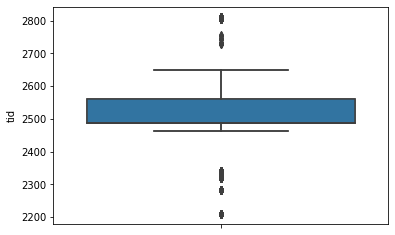

In [8]:
#箱线图查看单个变量的分布，以训练集中tid变量的前10000条数据绘制箱线图
sns.boxplot(y=train.iloc[:10000]["tid"])
plt.show()

In [9]:
#用nunique函数查看训练集中的变量取值分布
train.nunique()

file_id    13887
label          8
api          295
tid         2782
index       5001
dtype: int64

In [10]:
#查看训练集数据的缺少情况--结论不存在缺少
train.isnull().sum()

file_id    0
label      0
api        0
tid        0
index      0
dtype: int64

In [11]:
#判断是否有异常值--最大值最小值符合范围
train['index'].describe()

count    8.980669e+07
mean     1.547521e+03
std      1.412249e+03
min      0.000000e+00
25%      3.490000e+02
50%      1.085000e+03
75%      2.503000e+03
max      5.000000e+03
Name: index, dtype: float64

In [12]:
#判断是否有异常值--最大值最小值符合范围
train['tid'].describe()

count    8.980669e+07
mean     2.533028e+03
std      6.995798e+02
min      1.000000e+02
25%      2.356000e+03
50%      2.564000e+03
75%      2.776000e+03
max      2.089600e+04
Name: tid, dtype: float64

In [16]:
#测试集数据探索
test.head()

,file_id,api,tid,index
0,1,RegOpenKeyExA,2332,0
1,1,CopyFileA,2332,1
2,1,OpenSCManagerA,2332,2
3,1,CreateServiceA,2332,3
4,1,RegOpenKeyExA,2468,0


In [17]:
#查看测试集大小、数据类型信息
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79288375 entries, 0 to 79288374
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   file_id  int64 
 1   api      object
 2   tid      int64 
 3   index    int64 
dtypes: int64(3), object(1)
memory usage: 2.4+ GB


In [18]:
#查看测试集数据的缺失情况
test.isnull().sum()

file_id    0
api        0
tid        0
index      0
dtype: int64

In [19]:
#查看测试集中变量的取值分布
test.nunique()

file_id    12955
api          298
tid         2047
index       5001
dtype: int64

In [20]:
#异常值
test['index'].describe()

count    7.928838e+07
mean     1.584815e+03
std      1.411116e+03
min      0.000000e+00
25%      3.900000e+02
50%      1.131000e+03
75%      2.547000e+03
max      5.000000e+03
Name: index, dtype: float64

In [21]:
test['tid'].describe() 

count    7.928838e+07
mean     2.491914e+03
std      5.824600e+02
min      1.000000e+02
25%      2.360000e+03
50%      2.556000e+03
75%      2.752000e+03
max      9.196000e+03
Name: tid, dtype: float64

In [22]:
train_fields = train['file_id'].unique()
test_fileds = test['file_id'].unique()
len(set(train_fields)-set(test_fileds))

932

In [23]:
len(set(test_fileds)-set(train_fields))

0

In [24]:
#API分析
train_apis = train['api'].unique()
test_apis = test['api'].unique()
set(train_apis)-set(test_apis)

{'EncryptMessage', 'RtlCompressBuffer', 'WSASendTo'}

In [26]:
set(test_apis)-set(train_apis)

{'CreateDirectoryExW',
 'InternetGetConnectedStateExA',
 'MessageBoxTimeoutW',
 'NtCreateUserProcess',
 'NtDeleteFile',
 'TaskDialog'}

In [30]:
#内存管理
class _Data_Preprocess:
    def __init__(self):
        self.int8_max = np.iinfo(np.int8).max
        self.int8_min = np.iinfo(np.int8).min

        self.int16_max = np.iinfo(np.int16).max
        self.int16_min = np.iinfo(np.int16).min

        self.int32_max = np.iinfo(np.int32).max
        self.int32_min = np.iinfo(np.int32).min

        self.int64_max = np.iinfo(np.int64).max
        self.int64_min = np.iinfo(np.int64).min

        self.float16_max = np.finfo(np.float16).max
        self.float16_min = np.finfo(np.float16).min

        self.float32_max = np.finfo(np.float32).max
        self.float32_min = np.finfo(np.float32).min

        self.float64_max = np.finfo(np.float64).max
        self.float64_min = np.finfo(np.float64).min

    def _get_type(self,min_val,max_val,types):
        if types == 'int':
            if max_val<=self.int8_max and min_val>=self.int8_min:
                return np.int8
            elif max_val<= self.int16_max and min_val>=self.int16_min:
                return np.int16
            elif max_val<= self.int32_max and min_val>=self.int32_min:
                return np.int32
            return None
        elif types == 'float':
            if max_val <= self.float16_max and min_val >= self.float16_min:
                return np.float16
            elif max_val <= self.float32_max and min_val >= self.float32_min:
                return np.float32
            elif max_val <= self.float64_max and min_val >= self.float64_min:
                return np.float64
            return None

    def _memory_process(self,df):
        init_memory = df.memory_usage().sum()/1024**2/1024
        print('Original data occupies {} GB memory.'.format(init_memory))
        df_cols = df.columns
        for col in tqdm_notebook(df_cols):
            try:
                if 'float' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val,max_val,'float')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
                elif 'int' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'int')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
            except:
                print('can not do any process for column,{}.'.format(col))
                afterprocess_memory = df.memory_usage().sum()/1024**2/1024
                print('after processing, the data occupies {} GB memory.'.format(afterprocess_memory))
                return df

meomory_process = _Data_Preprocess()

# 特征工程与基线模型

In [31]:
def simple_sts_feature(df):
    simple_feature = pd.DataFrame()
    simple_feature['file_id'] = df['file_id'].unique()
    simple_feature['file_id'] = simple_feature.sort_values('file_id')

    df_grp = df.groupby('file_id')   
    simple_feature['file_id_api_count'] = df_grp['api'].count().values
    
    simple_feature['file_id_api_nunique'] = df_grp['api'].nunique().values

    simple_feature['file_id_tid_count'] = df_grp['tid'].count().values
    simple_feature['file_id_tid_nunique'] = df_grp['tid'].nunique().values

    simple_feature['file_id_index_count'] = df_grp['index'].count().values
    simple_feature['file_id_index_nunique'] = df_grp['index'].nunique().values

    return simple_feature

In [32]:
def simple_numerical_sts_feature(df):
    simple_feature = pd.DataFrame()
    simple_feature['file_id'] = df['file_id'].unique()
    simple_feature['file_id'] = simple_feature.sort_values('file_id')

    df_grp = df.groupby('file_id')

    simple_feature['file_id_tid_mean'] = df_grp['tid'].mean().values
    simple_feature['file_id_tid_min'] = df_grp['tid'].min().values
    simple_feature['file_id_tid_max'] = df_grp['tid'].max().values
    simple_feature['file_id_tid_std'] = df_grp['tid'].std().values

    simple_feature['file_id_index_mean'] = df_grp['index'].mean().values
    simple_feature['file_id_index_min'] = df_grp['index'].min().values
    simple_feature['file_id_index_max'] = df_grp['index'].max().values
    simple_feature['file_id_index_std'] = df_grp['index'].std().values

    return simple_feature

In [33]:
#构建特征
simple_train_feature1 = simple_sts_feature(train)
simple_test_feature1 = simple_sts_feature(test)


simple_train_feature2 = simple_numerical_sts_feature(train)
simple_test_feature2 = simple_numerical_sts_feature(test)

In [52]:
from tqdm import tqdm, tqdm_notebook
#特征工程进阶
def api_pivot_count_features(df):
    tmp = df.groupby(
        ['file_id','api']
    )['tid'].count().to_frame('api_tid_count').reset_index()
    tmp_pivot = pd.pivot_table(data = tmp,index='file_id',columns='api',values='api_tid_count',fill_value=0)
    
    tmp_pivot.columns = [tmp_pivot.columns.names[0]+'_pivot_'+str(col) for col in tmp_pivot.columns]
    
    tmp_pivot.reset_index(inplace=True)
#     tmp_pivot = meomory_process._memory_process(tmp_pivot)
    
    return tmp_pivot

def api_pivot_nunique_features(df):
    tmp = df.groupby(
        ['file_id', 'api']
    )['tid'].nunique().to_frame('api_tid_nunique').reset_index()
    tmp_pivot = pd.pivot_table(data=tmp, index='file_id', columns='api', values='api_tid_nunique', fill_value=0)
    tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_pivot_' + str(col) for col in tmp_pivot.columns]
    tmp_pivot.reset_index(inplace=True)
#     tmp_pivot = meomory_process._memory_process(tmp_pivot)
    return tmp_pivot


In [53]:
#特征获取
simple_train_feature3 = api_pivot_count_features(train)
simple_test_feature3 = api_pivot_count_features(test)

simple_train_feature4 = api_pivot_nunique_features(train)
simple_test_feature4 = api_pivot_nunique_features(test)
print(simple_train_feature3)

       file_id  api_pivot_AssignProcessToJobObject  \
0            1                                   0   
1            2                                   0   
2            3                                   0   
3            4                                   0   
4            5                                   0   
...        ...                                 ...   
13882    13883                                   0   
13883    13884                                   0   
13884    13885                                   0   
13885    13886                                   0   
13886    13887                                   0   

       api_pivot_CertControlStore  api_pivot_CertCreateCertificateContext  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   
3                               0          

In [26]:
print(simple_test_feature1)

       file_id  file_id_api_count  file_id_api_nunique  file_id_tid_count  \
0            1                 97                   15                 97   
1            2               1361                   40               1361   
2            3                 16                    9                 16   
3            4                193                   34                193   
4            5                803                   34                803   
...        ...                ...                  ...                ...   
12950    12951                289                   37                289   
12951    12952                112                   28                112   
12952    12953               5095                   72               5095   
12953    12954               2951                   65               2951   
12954    12955               2038                   54               2038   

       file_id_tid_nunique  file_id_index_count  file_id_index_nunique  
0 

In [27]:
print(simple_train_feature2)

       file_id  file_id_tid_mean  file_id_tid_min  file_id_tid_max  \
0            1       2537.987622             2488             2812   
1            2       2471.000000             2320             2604   
2            3       2208.000000             2208             2208   
3            4       2430.727273             2284             2980   
4            5       2549.731254             2500             2676   
...        ...               ...              ...              ...   
13882    13883       3544.762896              100             6568   
13883    13884       2592.118271             2592             2748   
13884    13885       2242.544046             2240             2744   
13885    13886       2483.399549             2324             2836   
13886    13887       2336.000000             2336             2336   

       file_id_tid_std  file_id_index_mean  file_id_index_min  \
0            83.881299         2000.806955                  0   
1           101.506783       

In [28]:
print(simple_test_feature2)

       file_id  file_id_tid_mean  file_id_tid_min  file_id_tid_max  \
0            1       2518.639175             2332             2568   
1            2       2576.864071             2472             2748   
2            3       2344.000000             2344             2344   
3            4       2476.331606             2452             2584   
4            5       2496.149440             2332             2780   
...        ...               ...              ...              ...   
12950    12951       2716.539792             2644             2980   
12951    12952       2264.000000             2264             2264   
12952    12953       2622.118155             2324             2884   
12953    12954       2593.646899             2424             2700   
12954    12955       2695.163886             2500             2740   

       file_id_tid_std  file_id_index_mean  file_id_index_min  \
0            57.218548           14.443299                  0   
1           104.399149       

In [54]:
#获取标签
train_label = train[['file_id','label']].drop_duplicates(subset = ['file_id','label'],keep = 'first')
test_submit = test[['file_id']].drop_duplicates(subset = ['file_id'],keep = 'first')

train_label
test_submit

,file_id
0,1
97,2
1458,3
1474,4
1667,5
...,...
79277890,12951
79278179,12952
79278291,12953
79283386,12954


In [55]:
#训练集和测试集的构建
train_data = train_label.merge(simple_train_feature1,on='file_id',how = 'left')
train_data = train_data.merge(simple_train_feature2,on='file_id',how = 'left')
print(simple_train_feature3)
train_data = train_data.merge(simple_train_feature3,on='file_id',how = 'left')
train_data = train_data.merge(simple_train_feature4,on='file_id',how = 'left')

test_submit = test_submit.merge(simple_test_feature1,on='file_id',how = 'left')
test_submit = test_submit.merge(simple_test_feature2,on='file_id',how = 'left')
test_submit = test_submit.merge(simple_test_feature3,on='file_id',how = 'left')
test_submit = test_submit.merge(simple_test_feature4,on='file_id',how = 'left')

       file_id  api_pivot_AssignProcessToJobObject  \
0            1                                   0   
1            2                                   0   
2            3                                   0   
3            4                                   0   
4            5                                   0   
...        ...                                 ...   
13882    13883                                   0   
13883    13884                                   0   
13884    13885                                   0   
13885    13886                                   0   
13886    13887                                   0   

       api_pivot_CertControlStore  api_pivot_CertCreateCertificateContext  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   
3                               0          

In [56]:
#查看训练集和测试集
print(train_data)

       file_id  label  file_id_api_count  file_id_api_nunique  \
0            1      5               6786                  116   
1            2      2                816                   30   
2            3      0                463                   42   
3            4      0               2046                   51   
4            5      0              10002                   65   
...        ...    ...                ...                  ...   
13882    13883      2             178221                   71   
13883    13884      5               1319                   39   
13884    13885      0               1033                   71   
13885    13886      1               5316                   80   
13886    13887      2                623                   37   

       file_id_tid_count  file_id_tid_nunique  file_id_index_count  \
0                   6786                   11                 6786   
1                    816                    4                  816   
2        

In [57]:
print(test_submit)

       file_id  file_id_api_count  file_id_api_nunique  file_id_tid_count  \
0            1                 97                   15                 97   
1            2               1361                   40               1361   
2            3                 16                    9                 16   
3            4                193                   34                193   
4            5                803                   34                803   
...        ...                ...                  ...                ...   
12950    12951                289                   37                289   
12951    12952                112                   28                112   
12952    12953               5095                   72               5095   
12953    12954               2951                   65               2951   
12954    12955               2038                   54               2038   

       file_id_tid_nunique  file_id_index_count  file_id_index_nunique  \
0

In [58]:
def lgb_logloss(preds,data):
    labels = data.get_label()
    classes = np.unique(labels)
    preds_prob = []
    for i in range(len(classes)):
        preds_prob.append(preds[i*len(labels):(i+1)*len(labels)])    
    preds_prob =  np.vstack(preds_prob)
    loss=[]
    for i in range(preds_prob.shape[1]):#样本个数
        sum = 0
        for j in range(preds_prob.shape[0]):#类别个数
            pred = preds_prob[j,i]#第i个样本预测为第j类的概率
            if j==labels[i]:
                sum+=np.log(pred)
            else:     
                sum+=np.log(1-pred)
        loss.append(sum)
    return 'loss is:',-1*(np.sum(loss)/preds_prob.shape[1]),False

In [59]:
#线下验证
train_features = [col for col in train_data.columns if col not in ['label','file_id']]
train_label = 'label'
from sklearn.model_selection import StratifiedKFold,KFold
params = {
    'task':'train',
    'num_leaves':255,
    'objective':'multiclass',
    'num_class':8,
    'min_data_in_leaf':50,
    'learning_rate':0.05,
    'feature_fraction':0.85,
    'bagging_fraction':0.85,
    'bagging_freq':5,
    'max_bin':128,
    'random_state':100,
    'verbosity': -1 
}
folds =KFold(n_splits=5,shuffle=True,random_state=15)
oof = np.zeros(len(train))

predict_res = 0
models = []
import lightgbm as lgb
for fold,(trn_id,val_id) in enumerate(folds.split(train_data)):
    print("fold n {}".format(fold))
    trn_data = lgb.Dataset(train_data.iloc[trn_id][train_features],label=train_data.iloc[trn_id][train_label].values)
    val_data = lgb.Dataset(train_data.iloc[val_id][train_features], label=train_data.iloc[val_id][train_label].values)
    clf = lgb.train(params,trn_data,num_boost_round=2000,valid_sets=[trn_data,val_data],verbose_eval=50,early_stopping_rounds=100,feval=lgb_logloss)
    models.append(clf)

fold n 0
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.183626	training's loss is:: 0.341959	valid_1's multi_logloss: 0.341377	valid_1's loss is:: 0.586353
[100]	training's multi_logloss: 0.0363207	training's loss is:: 0.0715909	valid_1's multi_logloss: 0.329024	valid_1's loss is:: 0.569227
[150]	training's multi_logloss: 0.00770209	training's loss is:: 0.0153632	valid_1's multi_logloss: 0.374909	valid_1's loss is:: 0.654556
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.0871876	training's loss is:: 0.168299	valid_1's multi_logloss: 0.32096	valid_1's loss is:: 0.552405
fold n 1
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.1821	training's loss is:: 0.339742	valid_1's multi_logloss: 0.371503	valid_1's loss is:: 0.626954
[100]	training's multi_logloss: 0.0361332	training's loss is:: 0.0712726	valid_1's multi_logloss: 0.361585	valid_1's loss is:: 0.612793
[150]	training's 

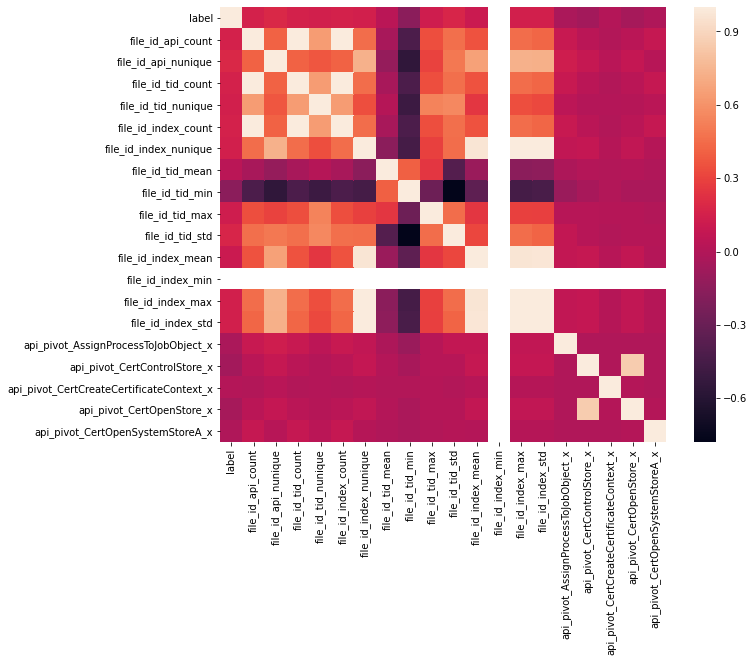

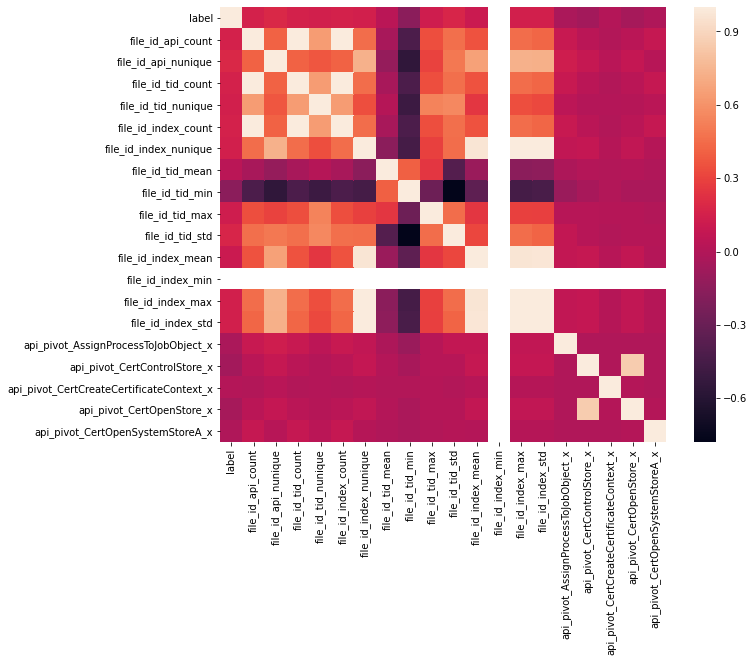

In [61]:
plt.figure(figsize=[10,8])
sns.heatmap(train_data.iloc[:10000,1:21].corr())
plt.show()

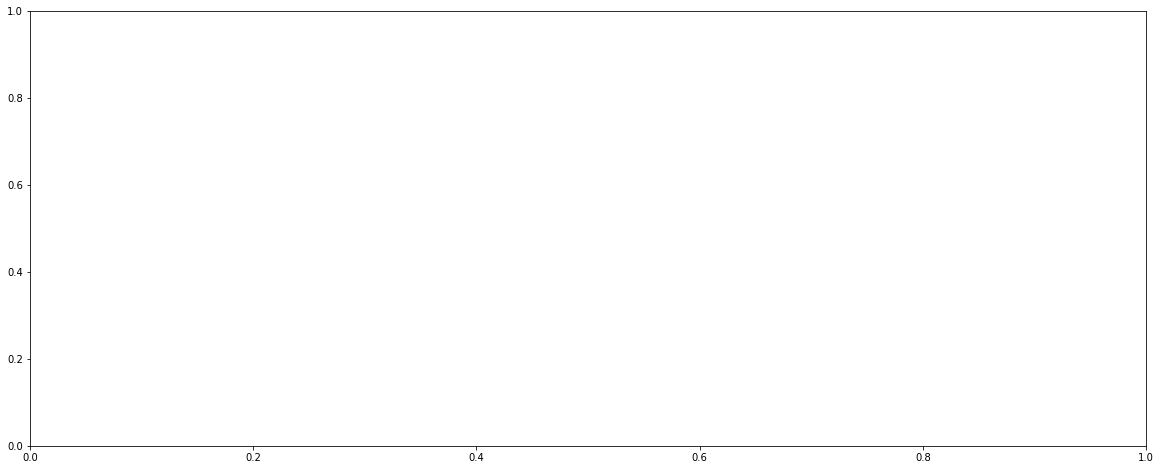

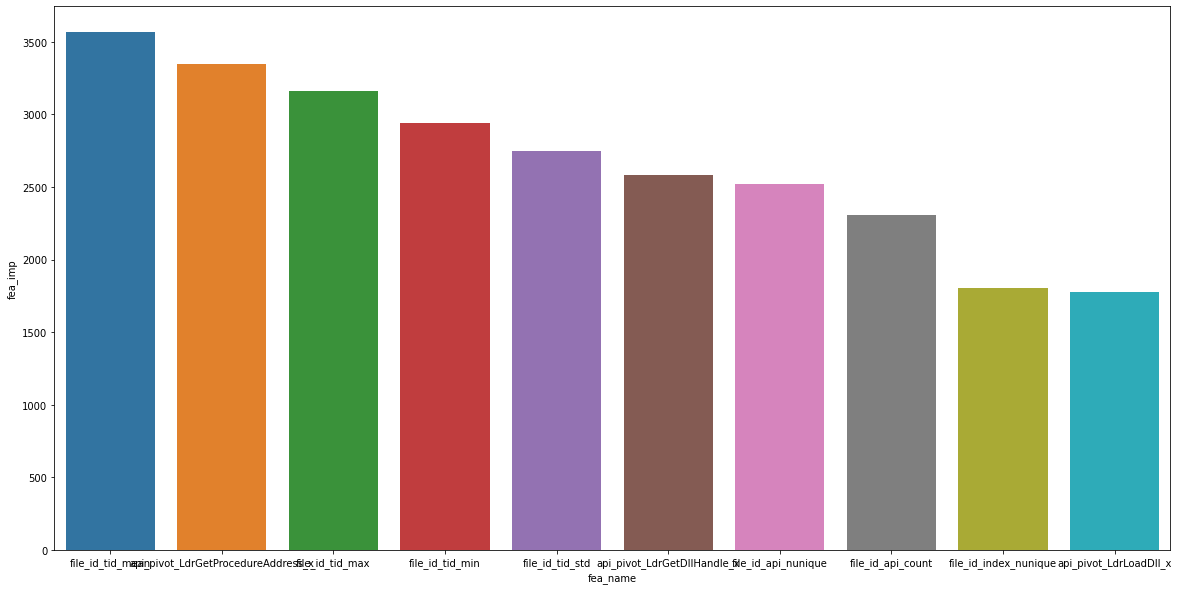

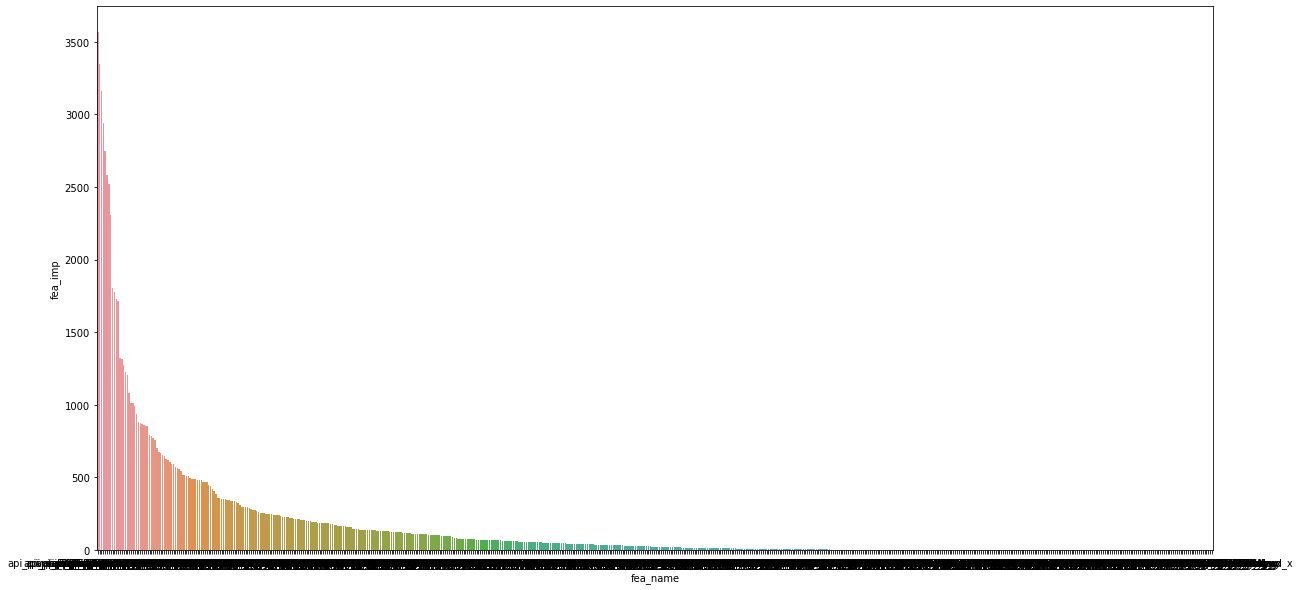

In [64]:
#特征重要性分析
import seaborn as sns
import matplotlib.pyplot as plt
feature_importance = pd.DataFrame()
feature_importance['fea_name'] = train_features
feature_importance['fea_imp' ] = clf.feature_importance()
feature_importance = feature_importance.sort_values('fea_imp',ascending=False)
plt.figure(figsize=[20,10,])

sns.barplot(x=feature_importance.iloc[:10]['fea_name'],y=feature_importance.iloc[:10]['fea_imp'])
plt.show()


plt.figure(figsize=[20,10,])

sns.barplot(x=feature_importance['fea_name'],y=feature_importance['fea_imp'])
plt.show()

# ax = lgb.plot_tree(clf,tree_index=1,figsize=(20,8),show_info=['split_gain'])
# plt.show()